# Dimensionality Reduction

In [37]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
import gif
from IPython.display import HTML
from sklearn.datasets import fetch_openml
import matplotlib.patches as mpatches


# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 400

## The notebook

In this notebook we want to look at the most abundant dimensionality reduction technique: Principle component analysis. Even much more sophisticated methods as a pre-processing step use PCA to get a first reduction of dimensionality. 
Therefore it is beneficial to get a firm understanding of the approach of PCA. We go through the same steps that have been introduced in the lecture in order to perform PCA on the MNIST dataset.

## Step 0 - The data

In [2]:
def transform_to_event_input(binned_spikes, bin_size=0.1):
    ''' transform binned_spike [spike train arrays, like np.array([0,0,0,1,0,0,1,0,1]) ]
        given the size of the bin bin_size 
        to arrays that cotain the spike times (and are easy to plot with the matplotlib event_plot function )'''
    
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times

def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we translate it to 1/ms, to match our dt dimension

    x = np.zeros(time_steps)
    
    rand_array =  np.random.rand(time_steps)
    x[rand_array < rate*dt] = 1
    
    _, events = transform_to_event_input(x, bin_size=dt)

    return events

In [3]:
def set_axes(ax):
    ax.grid(False)
    xticks = [0,10,20]
    yticks = [0,5,10]
    zticks = [0,10,20]



    ax.set(
        xticks = xticks,
        xlabel = 'Neuron 1 in Hz',
        yticks = yticks,
        ylabel = 'Neuron 2 in Hz',
        zticks = zticks,
        zlabel = 'Neuron 3 in Hz',    
    )
    ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.04))
    ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.08))
    ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.02))
    ax.set_xticklabels(xticks, fontsize=12)
    ax.set_yticklabels(yticks, fontsize=12)
    ax.set_zticklabels(zticks, fontsize=12)

(3, 40)


NameError: name 'pca' is not defined

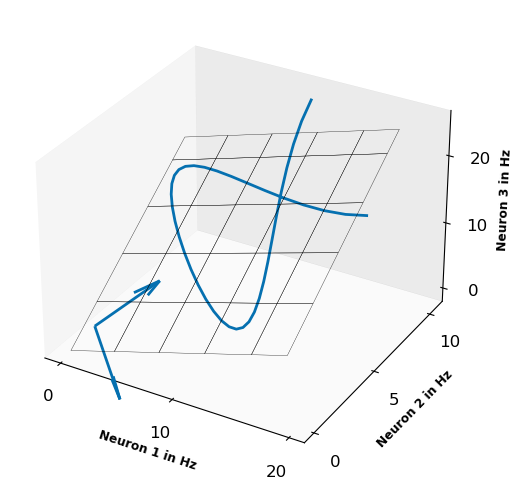

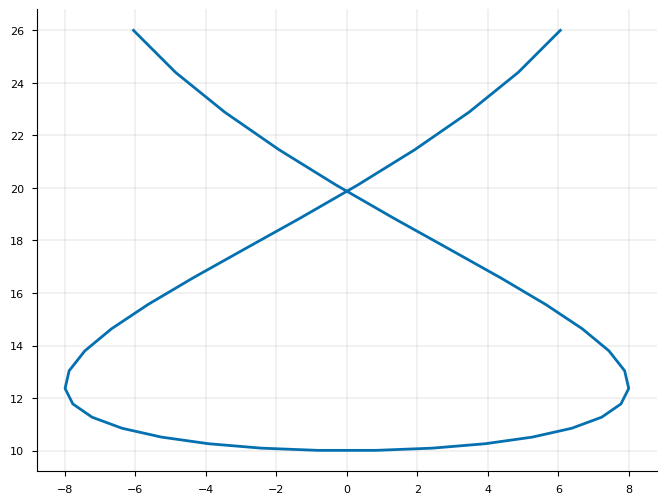

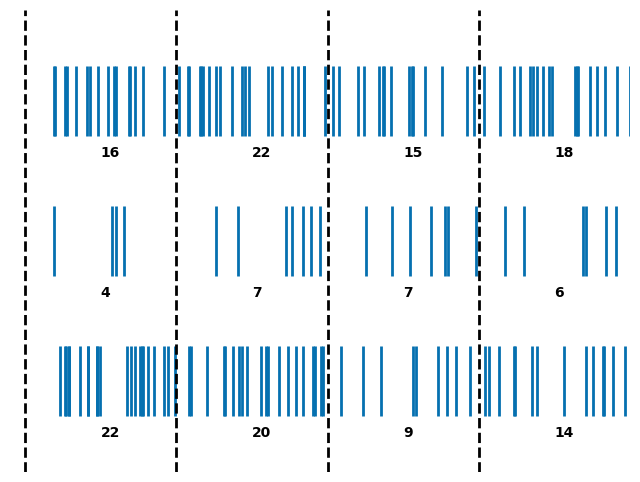

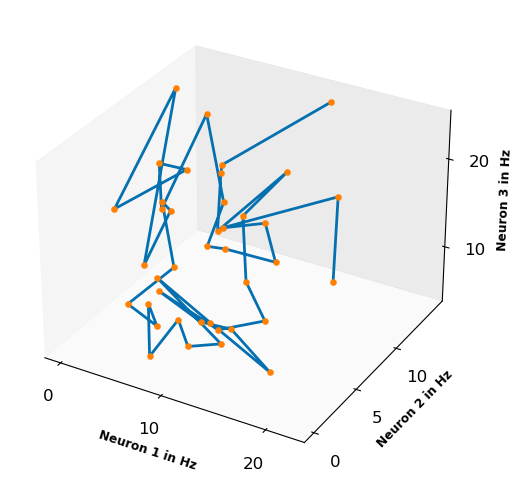

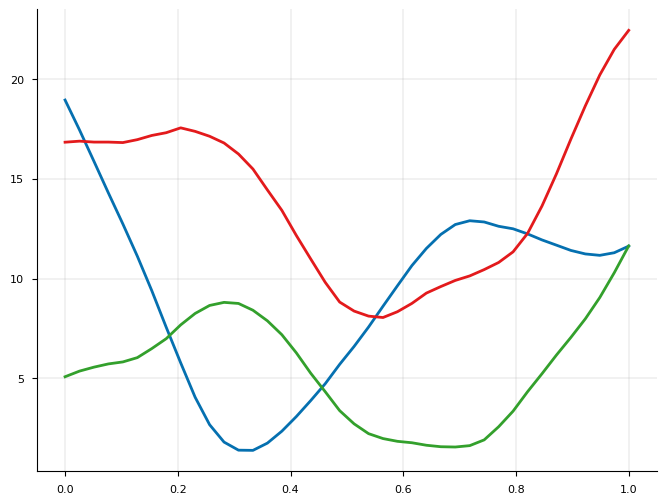

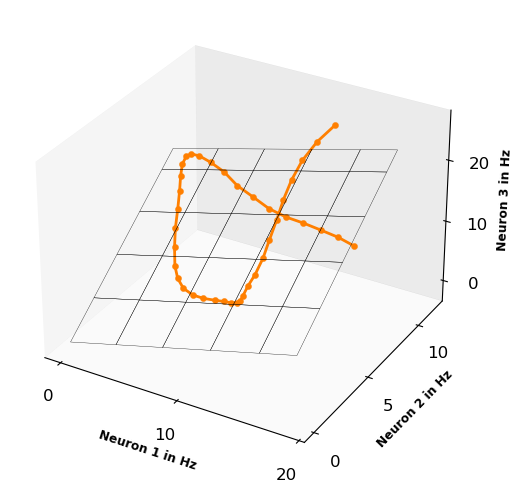

In [4]:


np.random.seed(42)

point_on_plane = np.array([1,1,1])
normal = np.array([1, 4, -2])
normal = normal/np.sqrt(np.sum(normal**2))

xx, yy = np.meshgrid(range(0,20), range(0,10))
zz = (point_on_plane.dot(normal)-normal[0] * xx - normal[1] * yy) /normal[2]

# calculate possible coordinate system of the plane
b1 = np.cross(point_on_plane, normal)
b2 = np.cross(b1, normal)

bv1=-b1/np.sqrt(np.sum(b1**2))
bv2=-b2/np.sqrt(np.sum(b2**2))


n_samples = 40
# create activity on the plane

min_activity = -4
max_activity = 4
activity_x = np.linspace(min_activity,max_activity,n_samples)

def get_a1(x):
    return np.sin(x)*8
    
    
def get_a2(x):
    return x**2+ 10
     
a1 = get_a1(activity_x)
a2 = get_a2(activity_x)
Z = np.array([x1*bv1+x2*bv2 + point_on_plane for x1,x2 in zip(a1,a2)]).T

# create plot
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx, yy, zz, color=(0,0,0,0), edgecolor='k', rcount=5, ccount=5)
ax.quiver(*point_on_plane, *bv1,length=7)
ax.quiver(*point_on_plane, *bv2, length=7)
ax.plot(*Z)


set_axes(ax)



fig, ax = plt.subplots()
ax.plot(a1, a2)


window_length = 1 # in s

all_spike_times = [np.array([])]*3
all_spikes = [np.array([])]*3
# we assume that the underlying rate of the process is valid for 1 s
for jj,val in enumerate(Z.T):
    for ii in range(3):
        spike_times = create_poisson_process(time_steps=int(10_000 * window_length), rate=val[ii],dt=0.1)
        spike_times += jj * window_length * 1_000 # transform to ms
        all_spike_times[ii] = np.hstack([all_spike_times[ii], spike_times])
        all_spikes[ii] = np.hstack([all_spikes[ii], np.array([len(spike_times)])])
        
fig,ax_spikes = plt.subplots()
ax_spikes.eventplot(all_spike_times,linelengths=0.5)
ax_spikes.axis('off')

stop_after = 4
ax_spikes.set_xlim([-100,1_000 * window_length * stop_after])

for jj in range(stop_after):
    t_in_ms = 1_000 * window_length
    ax_spikes.axvline(x=jj * t_in_ms, linestyle = '--', color='k')
    for ii in range(3):
        ax_spikes.annotate(f'{int(all_spikes[ii][jj])}', (jj*t_in_ms + t_in_ms/2., ii-0.4), fontweight='bold')

plt.savefig('dim_red_spike_trains.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

ax = plt.figure().add_subplot(projection='3d')
# ax.plot_surface(xx, yy, zz, color=(0,0,0,0), edgecolor='k', rcount=5, ccount=5)
set_axes(ax)
# ax.plot(*Z)
ax.plot(*np.array(all_spikes))
for jj,count in enumerate(np.array(all_spikes).T):
    ax.scatter(*count, color='#ff7f00')

    
plt.savefig('dim_red_spike_count_in_3d.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )    

# temporal smoothing of the spike trains
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

scale = 0.25
length = int(10 * window_length)
filter_array = gaussian(np.linspace(0,length,length+1), length//2, scale * length)

# ax_spikes.plot(np.linspace(0,length,length+1)*1_000,filter_array)
# fig, ax = plt.subplots()
# ax.plot(np.linspace(0,length,length+1)*1_000,filter_array)
all_filtered_signals = [[],[],[]]
for ii in range(3): 
    shift_ = len(filter_array)//2 + 1
    single_trial = all_spikes[ii]  
    
    shifted_trial = np.hstack([np.array([single_trial[0]]*shift_),single_trial,np.array([single_trial[-1]]*shift_)])
    filtered_signal = np.zeros(n_samples)

    for kk in range(n_samples):
        k_index = kk + shift_
        filtered = 1/window_length* len(filter_array) * np.mean(
            shifted_trial[k_index-len(filter_array)//2:k_index+len(filter_array)//2+1] * filter_array/np.sum(filter_array)
        )
        
        
        filtered_signal[kk] = filtered

    all_filtered_signals[ii] = filtered_signal
        
        
print (np.array(all_filtered_signals).shape)
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(all_filtered_signals[0])), all_filtered_signals[0])
ax.plot(np.linspace(0,1,len(all_filtered_signals[1])), all_filtered_signals[1])
ax.plot(np.linspace(0,1,len(all_filtered_signals[2])), all_filtered_signals[2])


ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx, yy, zz, color=(0,0,0,0), edgecolor='k', rcount=5, ccount=5)
# ax.plot(*Z)
ax.grid(False)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
ax.plot(*np.array(all_filtered_signals), c = '#ff7f00' )
for jj, count in enumerate(np.array(all_filtered_signals).T):
    ax.scatter(*count, color = colors[4]) #colors[jj%len(colors)])
#     ax.scatter(*Z.T[jj], color = colors[jj%len(colors)])


set_axes(ax)


plt.savefig('dim_red_smoothed_spikes_in_3d.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

all_filtered_signals = np.array(all_filtered_signals)
score, evectors, evals = pca(all_filtered_signals.T)



fig2, ax2 = plt.subplots()


# ax = plt.figure().add_subplot(projection='3d')
# ax.plot_surface(xx, yy, z, alpha=0.5)
# ax.plot(*Z)
# colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
for jj, count in enumerate(np.array(all_filtered_signals).T):
    
    ax2.scatter(*score[jj][:2], c = '#ff7f00')
#     if jj < 5 or jj > 10:
#         continue
    
#     print (count[0],evectors[0], count[1] ,evectors[1])
#     projected_point = count.dot(evectors[:,0]) * evectors[:,0] + count.dot(evectors[:,1]) * evectors[:,1] #+ count.dot(evectors[:,2]) * evectors[:,2]
#     ax.scatter(*projected_point, color = colors[jj%len(colors)], alpha=1)
# #     ax.scatter(*count, color = colors[jj%len(colors)])
#     ax.scatter(*Z.T[jj], color = colors[jj%len(colors)])
ticks = [-8,-4,0,4,8]
ax2.set(
        xticks = ticks,
        xlabel = 'Dim 1',
        yticks = ticks,
        ylabel = 'Dim 2',
)
ax2.set_xticklabels(ticks, fontsize=12)
ax2.set_yticklabels(ticks, fontsize=12)
    
plt.savefig('dim_red_projected_smooothed_spikes.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )
        
# print (evals.shape)
# ax.quiver(*point_on_plane, *bv1,length=7)
# ax.quiver(*point_on_plane, *bv2, length=7)

# ax.quiver(*point_on_plane, *evectors[:,0],length=7, color='k')
# ax.quiver(*point_on_plane, *evectors[:,1], length=7, color='k')

In [ ]:
ax = plt.figure().add_subplot(projection='3d')


point_on_plane = np.array([1,1,1])
normal = np.array([1, 1, -2])


normed_normal = normal/np.sqrt(np.sum(normal**2))

xx, yy = np.meshgrid(range(0,20), range(0,20))
z = (point_on_plane.dot(normal)-normal[0] * xx - normal[1] * yy) /normal[2]

ax.plot_surface(xx, yy, z, alpha=0.3)


c=normal[2]
zb2=normal[1]/c
zb1=normal[0]/c

b1=np.array([1,0,-zb1])
b2=np.array([0,1,-zb2])

bv1=b1/np.sqrt(np.sum(b1**2))
bv2=b2/np.sqrt(np.sum(b2**2))

ax.quiver(*point_on_plane, *bv1,length=7)
ax.quiver(*point_on_plane, *bv2, length=7)


X = np.linspace(-4,4,40)
a1 = np.sin(X)*8 + 9
a2 = X**2+ 1

Z = np.array([x1*bv1+x2*bv2 + point_on_plane for x1,x2 in zip(a1,a2)]).T

ax.plot(*Z)

fig, ax = plt.subplots()
ax.plot(a1, a2)
# ax.plot(X, a2)


window_length = 1 # in s

all_spike_times = [np.array([])]*3
all_spikes = [np.array([])]*3
# we assume that the underlying rate of the process is valid for 1 s
for jj,zz in enumerate(Z.T):
    for ii in range(3):
        spike_times, spikes = create_poisson_process(time_steps=10_000 * window_length, rate=zz[ii],dt=0.1)
        spike_times += jj * 1_000 * window_length
        all_spike_times[ii] = np.hstack([all_spike_times[ii], spike_times])
        all_spikes[ii] = np.hstack([all_spikes[ii], spikes])
        
fig,ax = plt.subplots()
ax.eventplot(all_spike_times,linelengths=0.5)
ax.axis('off')
ax.set_xlim([0,1_000 * window_length * 4])



all_counts = [[],[],[]]
for jj,zz in enumerate(Z.T):
    
    for ii in range(3):
        spike_count = np.sum( np.logical_and(all_spike_times[ii] >= jj*1_000 * window_length, all_spike_times[ii] < (jj+1) * 1_000*window_length))
        all_counts[ii].append(spike_count/window_length)


ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.plot(*Z)
for jj,count in enumerate(np.array(all_counts).T):
    ax.scatter(*count)
    

#     if jj >= 4:
#         break
        

n_samples = Z.shape[1]  
# temporal smoothing of the spike trains
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

scale = 3
length = 20_000 * window_length
filter_array = gaussian(np.linspace(0,length,length+1), length//2, scale * length)

all_filtered_signals = [[],[],[]]
for ii in range(3):
    
    shift_ = len(filter_array)//2 + 10
    single_trial = all_spikes[ii]
    shifted_trial = np.hstack([np.zeros(shift_),single_trial, np.zeros(shift_)])
    filtered_signal = np.zeros(n_samples)

    for kk in range(n_samples):
        k_index = kk * 10_000*window_length + 10_000//2 *window_length + shift_
        
        filtered = 10_000*len(filter_array) * np.mean(shifted_trial[k_index-len(filter_array)//2:k_index+len(filter_array)//2+1] * filter_array/np.sum(filter_array))
        filtered_signal[kk] = filtered

    all_filtered_signals[ii] = filtered_signal
        
        
print (np.array(all_filtered_signals).shape)
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(all_filtered_signals[0])), all_filtered_signals[0])
ax.plot(np.linspace(0,1,len(all_filtered_signals[1])), all_filtered_signals[1])
ax.plot(np.linspace(0,1,len(all_filtered_signals[2])), all_filtered_signals[2])


ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.plot(*Z)

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
for jj, count in enumerate(np.array(all_filtered_signals).T):
    if jj < 5:
        continue
    ax.scatter(*count, color = colors[jj%len(colors)])
    ax.scatter(*Z.T[jj], color = colors[jj%len(colors)])
    print (count, Z.T[jj], jj//len(colors))
    

    if jj >= 9:
        break
        


        
        
all_filtered_signals = np.array(all_filtered_signals)

print (all_filtered_signals.shape)

score, evectors, evals = pca(all_filtered_signals.T)

print (evals)
print (score.shape)
print (evectors.shape)

fig2, ax2 = plt.subplots()


ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.plot(*Z)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
for jj, count in enumerate(np.array(all_filtered_signals).T):
    
    ax2.scatter(*score[jj][:2])
    if jj < 5 or jj > 10:
        continue
    
    print (count[0],evectors[0], count[1] ,evectors[1])
    projected_point = count.dot(evectors[:,0]) * evectors[:,0] + count.dot(evectors[:,1]) * evectors[:,1] #+ count.dot(evectors[:,2]) * evectors[:,2]
    ax.scatter(*projected_point, color = colors[jj%len(colors)], alpha=1)
#     ax.scatter(*count, color = colors[jj%len(colors)])
    ax.scatter(*Z.T[jj], color = colors[jj%len(colors)])
    
    

        
# print (evals.shape)
ax.quiver(*point_on_plane, *bv1,length=7)
ax.quiver(*point_on_plane, *bv2, length=7)

ax.quiver(*point_on_plane, *evectors[:,0],length=7, color='k')
ax.quiver(*point_on_plane, *evectors[:,1], length=7, color='k')

In [ ]:
np.random.seed(12)
X = -0.9 + np.random.rand(45)*1.8
Y = 0.42*X + (-0.5 + np.random.rand(45))
fig, ax = plt.subplots()
ax.scatter(X,Y, c = '#1f78b4', s=30)
ax.set(
    xlim = [-1.15,1.15],
    ylim = [-1.15,1.15],
    xticklabels = [],
    yticklabels = [],
    xlabel = 'Wine Darkness',
    ylabel = 'Strength');
ax.yaxis.label.set_size(22)
ax.xaxis.label.set_size(22)
ax.set_box_aspect(1)


x = 2


theta  = np.pi*10/360.
alpha = np.tan(theta)
x_line = np.linspace(-1.4,1.4)


line_plot, = ax.plot(x_line,alpha*x_line, linewidth = 2.5, color = 'k', zorder=-10)
line_plots = []
scatter_plots = []
for xx,yy in zip(X,Y):
        v = np.array([1, alpha])
        projection = np.array([xx,yy])@v.T/(v.T@v)*v
        dummy, = ax.plot([xx,projection[0]],[yy,projection[1]], c='#EE0E1D',linewidth=1, linestyle = '--' )
        line_plots.append(dummy)
        scatter_plots.append(ax.scatter(*projection, c='#EE0E1D',s=30))
        
def animate(i):
    
    
    alpha = 2*np.pi*i/360.
    a = np.tan(alpha)
    line_plot.set_ydata(a*x_line)
    
    
    v = np.array([1, a])
    
    
    for jj, (xx,yy) in enumerate(zip(X,Y)):
        
        projection = np.array([xx,yy])@v.T/(v.T@v)*v
        line_plots[jj].set_ydata([yy,projection[1]])
        line_plots[jj].set_xdata([xx,projection[0]])
        scatter_plots[jj].set_offsets(projection)
        
    
    return line_plots

# Init only required for blitting to give a clean slate.
def init():
    line_plot.set_ydata(np.ma.array(x_line, mask=True))
    return line_plot,
        

In [ ]:
ani = FuncAnimation(fig, animate, frames=np.linspace(0, 179,360), init_func=init,
                              interval=20, blit=False)
# ani.save('animation.gif', writer='Pillow', fps=24)

HTML(ani.to_jshtml(fps=24,embed_frames=True))

In [ ]:
# project data into a new space

np.random.seed(12)

X = -0.9 + np.random.rand(45)*1.8
Y = 0.42*X + (-0.5 + np.random.rand(45))
# vec = np.array([[1,0.25],[0.5,1],[1,1]]).T
vec = np.vstack([X,Y])

print (vec.shape)




def interact(i):
    
    fig, (ax, new_ax) = plt.subplots(1,2, figsize=(12,6))
    ax.scatter(*vec, c = '#1f78b4', s=50)
    ax.set_box_aspect(1)


#     i = 120 # in degree


    # calculate
    alpha = 2*np.pi*i/360.
    a = np.tan(alpha)
    
    
    x_0 = 1
    if 90 < i <= 270:
        x_0 = -1
        a = -a


    vec_x = np.array([x_0,a])
    vec_y = np.array([-a,x_0])

    norm_x = vec_x/np.sqrt(np.sum(vec_x**2))
    norm_y = vec_y/np.sqrt(np.sum(vec_y**2))
    
    project_x = np.dot(norm_x, vec)
    project_y = np.dot(norm_y, vec)
      
                       
    # PLOT onto axes
    ax.quiver(0,0,*norm_x, scale = 2, color='#984ea3')
    ax.quiver(0,0,*norm_x*-1, scale = 2, color='#984ea3', headlength=0, headaxislength=0)
    ax.quiver(0,0,*norm_y, scale = 2, color='#ff7f00')
    ax.quiver(0,0,*norm_y*-1, scale = 2, color='#ff7f00', headlength=0, headaxislength=0)
    
    for bb, cc in zip([(norm_x * np.vstack([project_x,project_x]).T),(norm_y * np.vstack([project_y,project_y]).T)],( '#984ea3','#ff7f00')):
        
        ax.scatter(*bb.T, color = cc) 
        for a,b in zip(bb,vec.T):
            ax.plot([a[0],b[0]],[a[1],b[1]], linestyle = '--', color = cc)
            
                       
                       
    new_ax.scatter([project_x],[project_y], c = '#1f78b4', s=50)


    
        
    # Style of the axes
    for dummy_ax in [ax,new_ax]:
        
        dummy_ax.set(
            xlim = [-1.5,1.5],
            ylim = [-1.5,1.5])

        for axis in ['top','bottom','left','right']:
            dummy_ax.spines[axis].set_linewidth(2)
        dummy_ax.tick_params(width=2)

        x_ticks = [-1,0,1]
        y_ticks = [-1,0,1]
        dummy_ax.set_xticks(x_ticks)
        dummy_ax.set_xticklabels(x_ticks,fontsize=20)
        dummy_ax.set_yticks(y_ticks)
        dummy_ax.set_yticklabels(y_ticks,fontsize=20)
        
    ax.set_xlabel('$x_1$', fontsize=25, fontweight='bold')
    ax.set_ylabel('$x_2$', fontsize=25, rotation=0, fontweight='bold', labelpad=19)
    
    new_ax.set_xlabel('$c_1$', fontsize=25, fontweight='bold')
    new_ax.set_ylabel('$c_2$', fontsize=25, rotation=0, fontweight='bold', labelpad=19)
    
    new_ax.spines['left'].set_color('#ff7f00')
    new_ax.spines['bottom'].set_color('#984ea3')    
    
    
    plt.tight_layout()
widgets.interactive(interact, i=(0,359,1))

In [ ]:
def calculations(i, vec):
    # calculations
    alpha = 2*np.pi*i/360.
    a = np.tan(alpha)

    x_0 = 1
    if 90 < i <= 270:
        x_0 = -1
        a = -a


    vec_x = np.array([x_0,a])
    vec_y = np.array([-a,x_0])

    norm_x = vec_x/np.sqrt(np.sum(vec_x**2))
    norm_y = vec_y/np.sqrt(np.sum(vec_y**2))

    project_x = np.dot(norm_x, vec)
    project_y = np.dot(norm_y, vec)
    
    
    return vec_x, vec_y, norm_x, norm_y, project_x, project_y

In [ ]:
# project data into a new space
show_projection_line_plots = False



np.random.seed(12)
n_samples = 45

# create vector
X = -0.9 + np.random.rand(n_samples)*1.8
Y = 0.42*X + (-0.5 + np.random.rand(n_samples))
vec = np.vstack([X,Y])

# vec = np.array([[1,0.25]]).T








# calculations
vec_x, vec_y, norm_x, norm_y, project_x, project_y = calculations(i=0, vec=vec)


# # create figure
# fig, (ax, new_ax, matrix_ax) = plt.subplots(1,3, figsize=(18,9))
# create figure
fig, (ax, new_ax) = plt.subplots(1,2, figsize=(12,6))


# PLOT onto axes
# quiver_x_1 = ax.quiver(0,0,*norm_x, scale = 2, color='#984ea3')
# quiver_x_2 = ax.quiver(0,0,*norm_x*-1, scale = 2, color='#984ea3', headlength=0, headaxislength=0)
# quiver_y_1 = ax.quiver(0,0,*norm_y, scale = 2, color='#ff7f00')
# quiver_y_2 = ax.quiver(0,0,*norm_y*-1, scale = 2, color='#ff7f00', headlength=0, headaxislength=0)


# projection_scatter_plots = []
# projection_line_plots = []
# for bb, cc in zip([(norm_x * np.vstack([project_x,project_x]).T),(norm_y * np.vstack([project_y,project_y]).T)],( '#984ea3','#ff7f00')):

#     projection_scatter_plots.append(ax.scatter(*bb.T, color = cc)) 
    
#     if show_projection_line_plots:
#         for a,b in zip(bb,vec.T):
#             line_plot, = ax.plot([a[0],b[0]],[a[1],b[1]], linestyle = '--', color = cc) # the , is important
#             projection_line_plots.append(line_plot)
        
ax.scatter(*vec, c = '#1f78b4', s=50) # this remains constant



new_ax_scatter_plot = new_ax.scatter([project_x],[project_y], c = '#1f78b4', s=50)

cov_matrix = np.cov(vec)
print (cov_matrix)


# matrix_annotations = [[0,0],[0,0]]
# # Loop through the matrix and annotate each cell with its value using LaTeX formatting
# for ii in range(cov_matrix.shape[0]):
#     for jj in range(cov_matrix.shape[1]):
#         matrix_annotations[ii][jj] = matrix_ax.annotate(f'{np.round(cov_matrix[ii,jj],2)}', (jj*0.22+0.3,-ii*0.1+ 0.62),
#             textcoords='data', size=20, fontweight='bold')
        
#     matrix_ax.annotate(f'(', (0.1,0.5),
#             textcoords='data', fontsize=150, fontweight='ultralight')
    
#     matrix_ax.annotate(f')', (0.69,0.5),
#             textcoords='data', fontsize=150, fontweight='ultralight')
    
#     matrix_ax.axis('off')




# Style of the axes
for dummy_ax in [ax,new_ax]:
    dummy_ax.set_box_aspect(1)
    dummy_ax.set(
        xlim = [-1.5,1.5],
        ylim = [-1.5,1.5])

    for axis in ['top','bottom','left','right']:
        dummy_ax.spines[axis].set_linewidth(3)
    dummy_ax.tick_params(width=2)

    x_ticks = [-1,0,1]
    y_ticks = [-1,0,1]
    dummy_ax.set_xticks(x_ticks)
    dummy_ax.set_xticklabels(x_ticks,fontsize=20)
    dummy_ax.set_yticks(y_ticks)
    dummy_ax.set_yticklabels(y_ticks,fontsize=20)

ax.set_xlabel('$x_1$', fontsize=25, fontweight='bold')
ax.set_ylabel('$x_2$', fontsize=25, rotation=0, fontweight='bold', labelpad=19)

new_ax.set_xlabel('$c_1$', fontsize=25, fontweight='bold')
new_ax.set_ylabel('$c_2$', fontsize=25, rotation=0, fontweight='bold', labelpad=19)

new_ax.spines['left'].set_color('#ff7f00')
new_ax.spines['bottom'].set_color('#984ea3')    
plt.tight_layout()




In [ ]:
def animate(i):
    
    
    vec_x, vec_y, norm_x, norm_y, project_x, project_y = calculations(i, vec=vec)
    
    
#     # PLOT onto axes
    quiver_x_1.set_UVC(*norm_x)
    quiver_x_2.set_UVC(*norm_x*-1) 
    quiver_y_1.set_UVC(*norm_y)
    quiver_y_2.set_UVC(*norm_y*-1)


    
    for ii, (bb, cc) in enumerate(zip([(norm_x * np.vstack([project_x,project_x]).T),(norm_y * np.vstack([project_y,project_y]).T)],( '#984ea3','#ff7f00'))):

        projection_scatter_plots[ii].set_offsets(bb) 
        if show_projection_line_plots:
            for jj, (a,b) in enumerate(zip(vec.T,bb)):
                projection_line_plots[ii * len(bb)+ jj].set_ydata([a[1],b[1]])
                projection_line_plots[ii * len(bb)+ jj].set_xdata([a[0],b[0]])

    projected_vec = np.vstack([project_x,project_y]).T
    new_ax_scatter_plot.set_offsets(projected_vec)
        
        
        
#     cov_matrix = np.cov(projected_vec.T)    
            
#     for ii in range(cov_matrix.shape[0]):
#         for jj in range(cov_matrix.shape[1]):
#             matrix_annotations[ii][jj].set_text(f'{np.round(cov_matrix[ii,jj],2)}')
                
                
    
    return projection_scatter_plots

ani = FuncAnimation(fig, animate, frames=np.linspace(0, 359,360),
                              interval=20, blit=False)
# ani.save('projection.gif', writer='Pillow', fps=24)

HTML(ani.to_jshtml(fps=24,embed_frames=True))

In [ ]:
import matplotlib.pyplot as plt

# Coordinates of the starting and ending points of the arrow
x1, y1 = 0, 0
x2, y2 = 3, 4

# Displacements in the x and y directions from the starting point to the ending point
u = x2 - x1
v = y2 - y1

# Plot the arrow using quiver
plt.quiver(x1, y1, u, v, color='r', scale=1)

# Add some labels and show the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Arrow between two points')
plt.xlim([0,5])
plt.ylim([0,5])
plt.show()

In [ ]:
def AAA(alpha=70):
    np.random.seed(15)

    X = -0.5 + np.random.rand(45)
    Y = X + (-0.5 + np.random.rand(45))*0.5

    fig, ax = plt.subplots()
    ax.scatter(X,Y)
    ax.set(
        xlim = [-1,1],
        ylim = [-1,1],
#         xticklabels = [],
#         yticklabels = [],
        xlabel = 'Wine Darkness',
        ylabel = 'Strength');


    theta  = 2*np.pi*alpha/360.
    m = np.tan(theta)
    x_line = np.linspace(-1,1,1000)


#     line_plot, = ax.plot(x_line,alpha*x_line)
    line_plots = []
    scatter_plots = []
    
    def normalized(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return (a / np.expand_dims(l2, axis))[0]
    
    v = np.array([1, m])
    v = normalized(v)
    
    ax.scatter([0],[0],color='k')
    
    
    def circle(x, minus=1):
        return minus * np.sqrt(1 - x**2)
    
    xxx = np.linspace(-1,1,1000)
    ax.plot(xxx,circle(xxx),'k')
    ax.plot(xxx,circle(xxx,-1),'k')

    ax.set_box_aspect(1)
    for xx,yy in zip(X,Y):         
            
            projection = np.dot(np.array([xx,yy]),v)/np.dot(v,v)*v
            dummy, = ax.plot([xx,projection[0]],[yy,projection[1]], 'r',linewidth=0.5, linestyle = '--' )
            line_plots.append(dummy)
            scatter_plots.append(ax.scatter([projection[1]],[projection[0]], c='r',s=24))

        



widgets.interactive(AAA,alpha=(0,179,10))


\begin{equation}
U = m \cdot K + b
\end{equation}

Die Äquivalenz können wir nun sehen, wenn wir uns die Gleichung des Neurons genauer anschauen:

\begin{equation}
z = K \cdot w_1 + U \cdot w_2
\end{equation}

Nun wissen wir, dass das Neuron einen Punkt der Klasse $A$ zuordnet, wenn $z<s$ gilt, und der Klasse $B$, wenn $z>s$ gilt. 
Das bedeutet, dass wir bei $z=s$ eine Grenze zwischen den beiden Klassen ziehen können.
Wenn wir $z=s$ einsetzen und nach $U$ umformen, bekommen wir:

\begin{equation}
z = K \cdot w_1 + U \cdot w_2 = s \qquad \Leftrightarrow \qquad U \cdot w_2 = - K \cdot w_1 + s \qquad \Leftrightarrow \qquad U = \left(-\frac{w_1}{w_2}\right) \cdot K + \frac{s}{w_2}
\end{equation}

Hier sehen wir die selbe Geradengleichung wie zu Beginn, wenn wir $m=\left(-\frac{w_1}{w_2}\right)$ und $b=\frac{s}{w_2}$ setzen.
    


In [ ]:
def pca(X):
    """
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

    Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

    Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

    """

    X = X - np.mean(X, 0)
    cov_matrix = get_sample_cov_matrix(X)
    evals, evectors = np.linalg.eigh(cov_matrix)
    evals, evectors = sort_evals_descending(evals, evectors)
    score = change_of_basis(X, evectors)

    return score, evectors, evals

def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                            different random variable

    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    X = X - np.mean(X, 0)
    cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
    return cov_matrix

def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0],
                               1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1],
                               1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]

    return evals, evectors

def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)

    return Y

In [ ]:
np.random.seed(12)

X = -0.9 + np.random.rand(45)*1.8 + 1
Y = 0.42*X + (-0.5 + np.random.rand(45)) - 0.7
vec = np.vstack([X,Y])

def plot_scatter(vec):
    

    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(*vec, c = '#1f78b4', s=50)
    ax.set_box_aspect(1)

    ax.set(
        xlim = [-1.5,1.5],
        ylim = [-1.5,1.5])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)

    x_ticks = [-1,0,1,2]
    y_ticks = [-1,0,1]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks,fontsize=20)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks,fontsize=20)

    ax.set_xlabel('Feature 1', fontsize=25, fontweight='bold')
    ax.set_ylabel('Feature 2', fontsize=25, fontweight='bold', labelpad=19)
    plt.tight_layout()
    
    return ax

plot_scatter(vec)

X = X - np.mean(X)
Y = Y - np.mean(Y)
vec = np.vstack([X,Y])
plot_scatter(vec)


score, evectors, evals = pca(vec.T)
print (evectors.shape)

ax = plot_scatter(vec)
ax.quiver(0,0,*evectors[:,0], scale = 2, color='#FF8E00')
ax.quiver(0,0,*evectors[:,0]*-1, scale = 2, color='#FF8E00', headlength=0, headaxislength=0)
ax.quiver(0,0,*evectors[:,1], scale = 2, color='#19891F')
ax.quiver(0,0,*evectors[:,1]*-1, scale = 2, color='#19891F', headlength=0, headaxislength=0)


projected_vec = np.matmul(vec.T,evectors)
ax = plot_scatter(projected_vec.T)
ax.set(
    xlabel = 'Principle Component 1',
    ylabel = 'Principle Component 2')



X = -5 + np.random.rand(45)*10 
Y = X/15 + (-0.1 + np.random.rand(45)*0.2) 
vec = np.vstack([X,Y])

ax = plot_scatter(vec)
ax.set(
    xlabel = 'Neuron 1',
    ylabel = 'Neuron 2')
ax.set(
    xlim = [-6,6])

x_ticks = [-5,0,5]

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)
score, evectors, evals = pca(vec.T)
ax.quiver(0,0,*evectors[:,0], scale = 2, color='#FF8E00')
ax.quiver(0,0,*evectors[:,0]*-1, scale = 2, color='#FF8E00', headlength=0, headaxislength=0)
ax.quiver(0,0,*evectors[:,1], scale = 2, color='#19891F')
ax.quiver(0,0,*evectors[:,1]*-1, scale = 2, color='#19891F', headlength=0, headaxislength=0)
projected_vec = np.matmul(vec.T,evectors)
ax = plot_scatter(projected_vec.T)
ax.set(
    xlabel = 'Principle Component 1',
    ylabel = 'Principle Component 2')
ax.set(
    xlim = [-6,6])
x_ticks = [-5,0,5]

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)




X = X/np.std(X)
Y = Y/np.std(Y)
print (X)
vec = np.vstack([X,Y])
ax = plot_scatter(vec)
ax.set(
    xlabel = 'Neuron 1',
    ylabel = 'Neuron 2')
x_ticks = [-2,-1,0,1,2]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)
score, evectors, evals = pca(vec.T)
ax.quiver(0,0,*evectors[:,0], scale = 2, color='#FF8E00')
ax.quiver(0,0,*evectors[:,0]*-1, scale = 2, color='#FF8E00', headlength=0, headaxislength=0)
ax.quiver(0,0,*evectors[:,1], scale = 2, color='#19891F')
ax.quiver(0,0,*evectors[:,1]*-1, scale = 2, color='#19891F', headlength=0, headaxislength=0)
projected_vec = np.matmul(vec.T,evectors)
ax = plot_scatter(projected_vec.T)
ax.set(
    xlabel = 'Principle Component 1',
    ylabel = 'Principle Component 2')

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)



X = -0.4 + np.random.rand(45)*2
Y = -X*0.9 + np.random.rand(45)
Y[22:] += 1

X -= np.mean(X)
Y -= np.mean(Y)
vec = np.vstack([X,Y])

fig, ax_main = plt.subplots(figsize=(6,6))
ax_main.scatter(*vec[:,:22], c = '#1f78b4', s=50)
ax_main.scatter(*vec[:,22:], c = '#984ea3', s=50)
ax_main.set_box_aspect(1)

ax_main.set(
    xlim = [-1.5,1.5],
    ylim = [-1.5,1.5])

for axis in ['top','bottom','left','right']:
    ax_main.spines[axis].set_linewidth(2)
ax_main.tick_params(width=2)

x_ticks = [-1,0,1,2]
y_ticks = [-1,0,1]
ax_main.set_xticks(x_ticks)
ax_main.set_xticklabels(x_ticks,fontsize=20)
ax_main.set_yticks(y_ticks)
ax_main.set_yticklabels(y_ticks,fontsize=20)

ax_main.set_xlabel('Neuron 1', fontsize=25, fontweight='bold')
ax_main.set_ylabel('Neuron 2', fontsize=25, fontweight='bold', labelpad=19)
plt.tight_layout()


score, evectors, evals = pca(vec.T)
ax_main.quiver(0,0,*evectors[:,0], scale = 2, color='k')
ax_main.quiver(0,0,*evectors[:,0]*-1, scale = 2, color='k', headlength=0, headaxislength=0)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_trans = lda.fit_transform(vec.T, np.hstack([np.zeros(22),np.ones(23)]))
print(lda.coef_.shape)

evec_lda = lda.coef_[0]/np.sqrt(np.sum(lda.coef_[0]**2))
ax_main.quiver(0,0,*evec_lda, scale = 2, color='k', ec='k', linewidth=1, fc = 'w')
ax_main.quiver(0,0,*evec_lda*-1, scale = 2, color='k', ec='k', linewidth=1, fc = 'w', headlength=0, headaxislength=0)

projected_vec = np.matmul(vec.T,evectors)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(projected_vec[:22,0].T,np.zeros(22), c = '#1f78b4', s=50)
ax.scatter(projected_vec[22:,0].T,np.zeros(23), c = '#984ea3', s=50)
ax.set_box_aspect(1)

ax.set(
    xlim = [-1.5,1.5],
    ylim = [-1.5,1.5])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

x_ticks = [-3,0,3]
y_ticks = [-1,0,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)
ax.set_yticks(y_ticks)
ax.set_yticklabels([],fontsize=20)

ax.set_xlabel('Principle Component 1', fontsize=25, fontweight='bold')
ax.set_ylabel('', fontsize=25, fontweight='bold', labelpad=19)
plt.tight_layout()






fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_trans[:22,:],np.zeros(22), c = '#1f78b4', s=50)
ax.scatter(X_trans[22:,:],np.zeros(23), c = '#984ea3', s=50)
ax.set_box_aspect(1)
ax.set(
    ylim = [-1.5,1.5])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

x_ticks = [-5,0,5]
y_ticks = [-1,0,1]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)
ax.set_yticks(y_ticks)
ax.set_yticklabels([],fontsize=20)

ax.set_xlabel('LDA axis', fontsize=25, fontweight='bold')
ax.set_ylabel('', fontsize=25, fontweight='bold', labelpad=19)
plt.tight_layout()


In [6]:
def pca(X):
    """
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

    Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

    Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

    """

    X = X - np.mean(X, 0)
    cov_matrix = get_sample_cov_matrix(X)
    evals, evectors = np.linalg.eigh(cov_matrix)
    evals, evectors = sort_evals_descending(evals, evectors)
    score = change_of_basis(X, evectors)

    return score, evectors, evals

def get_sample_cov_matrix(X):
    """
    Returns the sample covariance matrix of data X.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                            different random variable

    Returns:
    (numpy array of floats)   : Covariance matrix
    """

    X = X - np.mean(X, 0)
    cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
    return cov_matrix

def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
    eigenvectors to be in first two quadrants (if 2D).

    Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

    Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0],
                               1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1],
                               1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]

    return evals, evectors

def change_of_basis(X, W):
    """
    Projects data onto a new basis.

    Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

    Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
    """

    Y = np.matmul(X, W)

    return Y

In [7]:
mnist = fetch_openml(name='mnist_784', as_frame = False)
X = mnist.data

(70000, 784)


(84.0, 0.0, 84.0, 0.0)

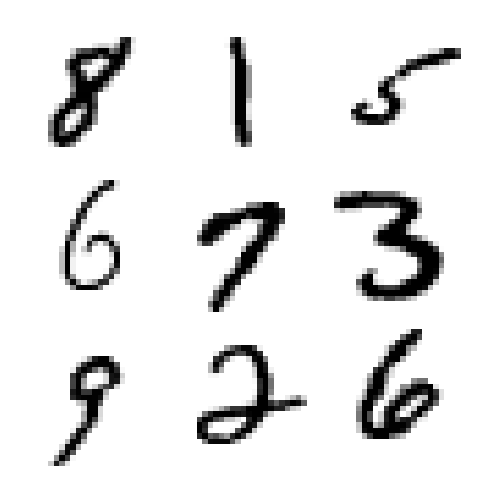

In [8]:
print (X.shape)
# show some MNIS samples
fig, ax = plt.subplots()
k = 10
for k1 in range(3):
    for k2 in range(3):
        k = k + 1
        ax.imshow(np.reshape(X[k, :], (28, 28)),
             extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
             vmin=0, vmax=255, cmap = 'binary')
ax.set(
    xlim = (3 * 28, 0),
    ylim = (3 * 28, 0),
)
ax.axis('off')

[Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Eigenvalue'),
 Text(0.5, 1.0, 'Scree plot'),
 (0.0, 70.0)]

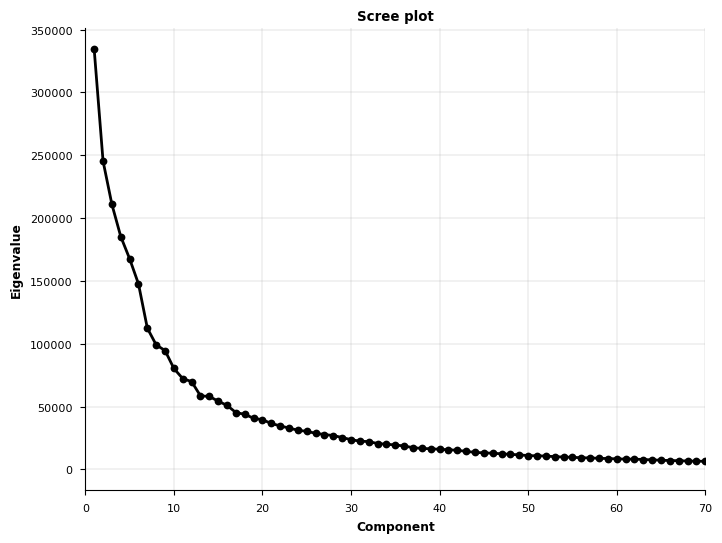

In [131]:
score, evectors, evals = pca(X)

fig, ax = plt.subplots()
ax.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
ax.set(
    xlabel ='Component',
    ylabel ='Eigenvalue',
    title = 'Scree plot',
    xlim=[0,70])

259


[Text(0.5, 0, 'Number of components'), Text(0, 0.5, 'Variance explained')]

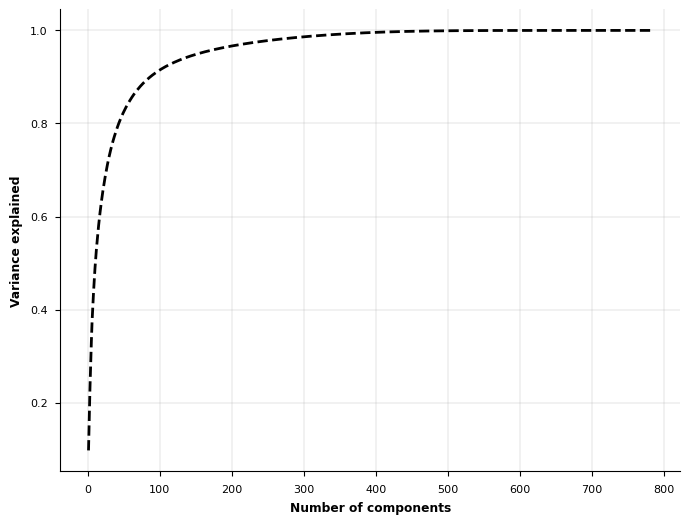

In [10]:
fig, ax = plt.subplots()
csum = np.cumsum(evals)

# Normalize by the sum of eigenvalues
variance_explained = csum / np.sum(evals)

print (np.argmax(variance_explained > 0.98))
ax.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
       '--k')
ax.set(
    xlabel ='Number of components',
    ylabel = 'Variance explained')

(-0.5, 27.5, 27.5, -0.5)

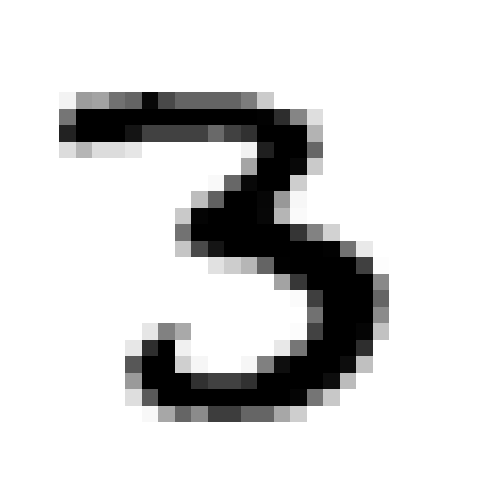

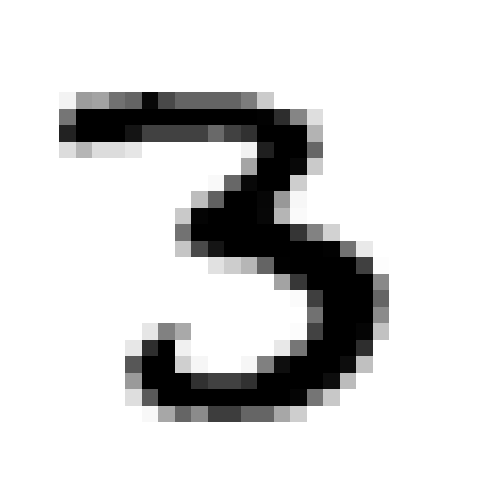

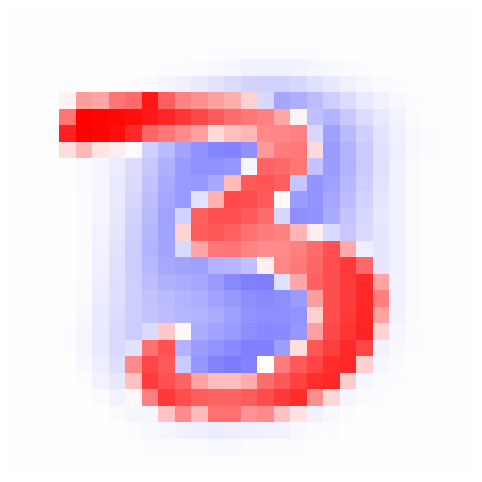

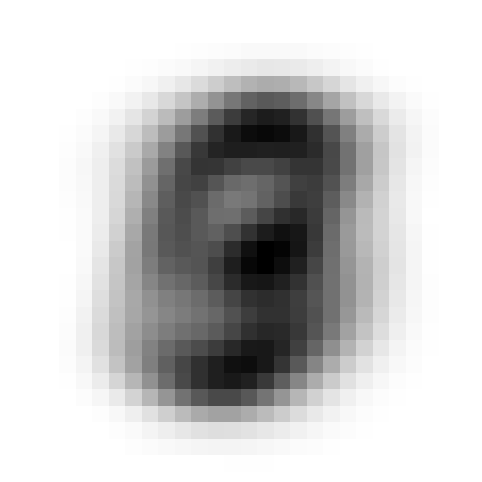

In [157]:
K = 649

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed =  np.matmul(score[:, :K], evectors[:, :K].T) + X_mean
X_reconstructed_without_mean =  np.matmul(score[:, :K], evectors[:, :K].T)

fig, ax = plt.subplots()
ax.imshow((X[12]).reshape((28,28)), cmap='binary')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(X_reconstructed[12].reshape((28,28)), cmap='binary', vmin=0, vmax=255)


ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(X_reconstructed_without_mean[12].reshape((28,28)), cmap='bwr',vmin=-255,vmax=255)
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(X_mean.reshape((28,28)), cmap='binary')
ax.axis('off')

-140.01505714285713 254.98591428571427


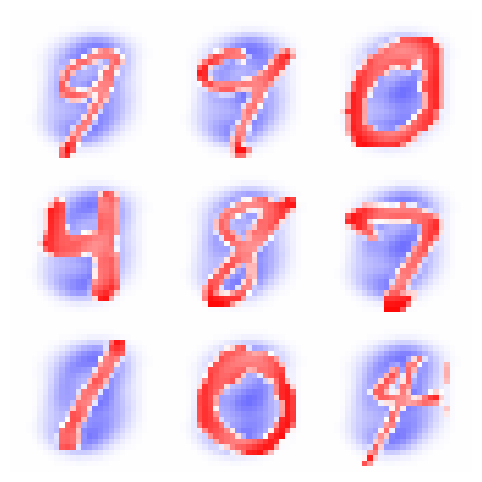

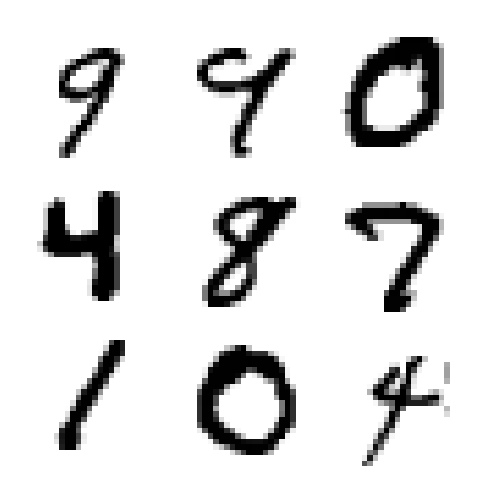

In [35]:

fig, ax = plt.subplots()
k = 50
for k1 in range(3):
    for k2 in range(3):
        k = k + 1
        ax.imshow(np.reshape(X[k, :]-X_mean, (28, 28)),
             extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
              vmin = -255, vmax = 255, cmap = 'bwr')
ax.set(
    xlim = (3 * 28, 0),
    ylim = (3 * 28, 0),
)
ax.axis('off')

fig, ax = plt.subplots()
k = 50
for k1 in range(3):
    for k2 in range(3):
        k = k + 1
        ax.imshow(np.reshape(X[k, :], (28, 28)),
             extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
             cmap = 'binary')
ax.set(
    xlim = (3 * 28, 0),
    ylim = (3 * 28, 0),
)
ax.axis('off')

print (np.min(X-X_mean), np.max(X-X_mean))

-140.01505714285713 254.98591428571427
1389.7963171426559
606.8016361171436
-555.7921471724491
722.0122932008172
706.3474413171425
205.17586234571385


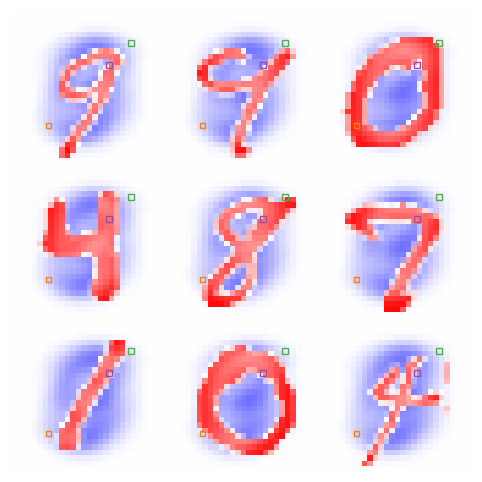

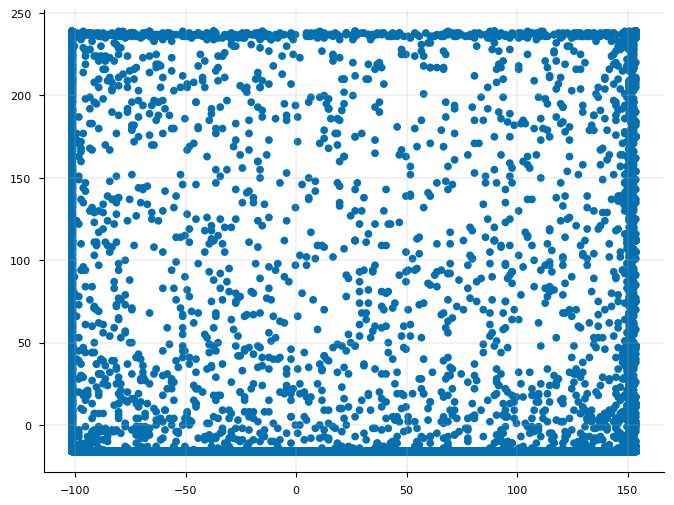

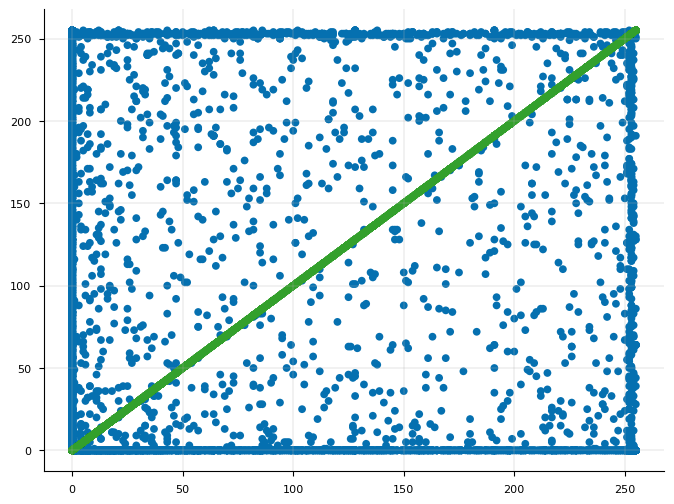

In [57]:
fig, ax = plt.subplots()
k = 50

i,j = [10, 21, 6],[10, 21, 6]
colors = ['#984ea3','#ff7f00','#4daf4a']

for k1 in range(3):
    for k2 in range(3):
        k = k + 1
        ax.imshow(np.reshape(X[k, :]-X_mean, (28, 28)),
             extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
             vmin = -255, vmax = 255,cmap = 'bwr')
        for ll in range(3):
            rect= mpatches.Rectangle((k1 * 28 + i[ll]-0.5,k2 * 28 + j[ll]-0.5),1,1, 
                            fill=False,
                            color=colors[ll],
                           linewidth=1)
                           #facecolor="red")
            ax.add_patch(rect)
ax.set(
    xlim = (3 * 28, 0),
    ylim = (3 * 28, 0),
)
ax.axis('off')

fig, ax = plt.subplots()
ax.scatter((X-X_mean)[:,10*28+10], (X-X_mean)[:,21*28+21])

fig, ax = plt.subplots()
ax.scatter(X[:,6*28+6], X[:,21*28+21])

ax.scatter(X[:,6*28+6], X[:,6*28+6])

print (np.min(X-X_mean), np.max(X-X_mean))

print (get_sample_cov_matrix(X)[6*28+6,6*28+6])
print (get_sample_cov_matrix(X)[6*28+6,21*28+21])
print (get_sample_cov_matrix(X)[6*28+6,10*28+10])
print (get_sample_cov_matrix(X)[10*28+6,10*28+21])
print (get_sample_cov_matrix(X)[10*28+6,21*28+21])
print (get_sample_cov_matrix(X)[21*28+6,21*28+21])


-0.10770709203739166 0.07565134288786891
334289.28578912903


(-0.5, 27.5, 27.5, -0.5)

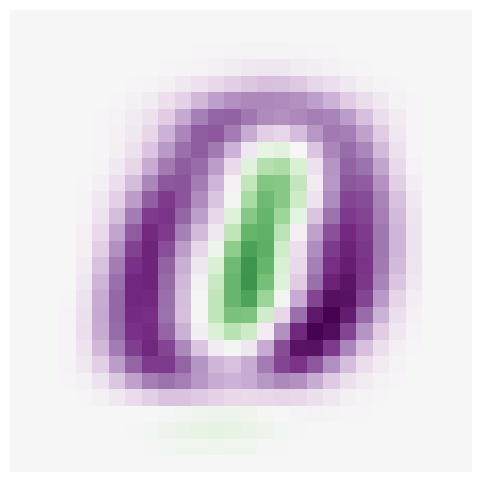

In [62]:
score, evectors, evals = pca(X)

334289.28578912903
245429.9209524571
210927.3412949321
3350.179491531724
1592.2968744717089
202.0930415614546
-2.3280029341941893e-11


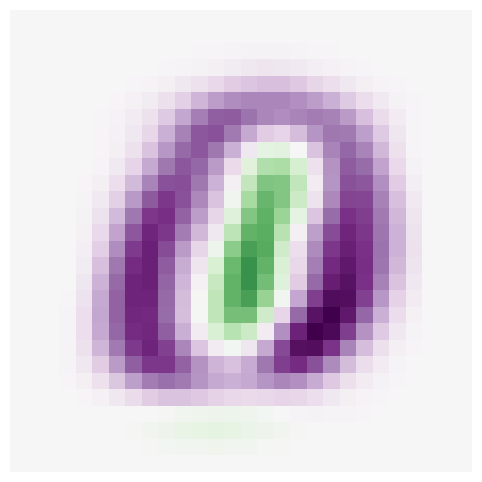

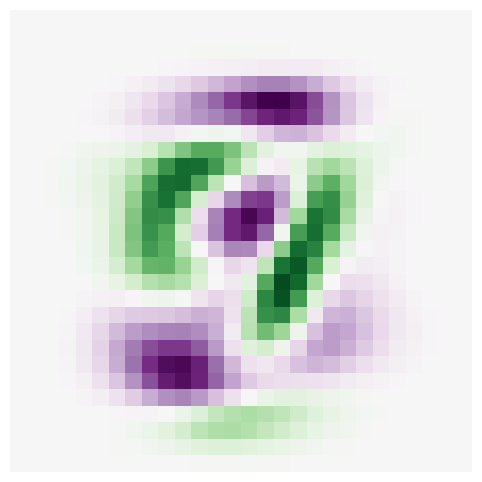

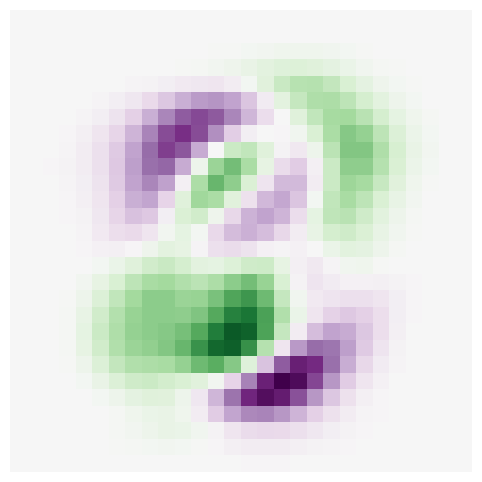

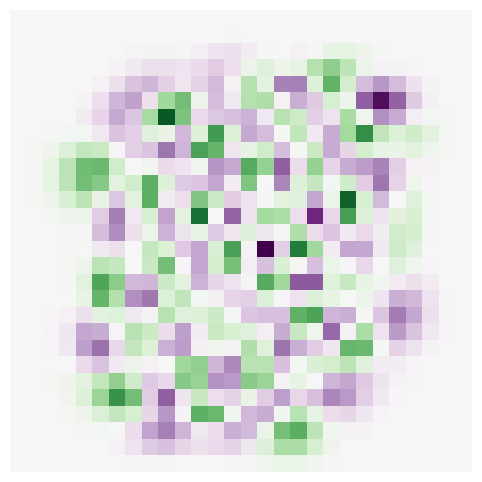

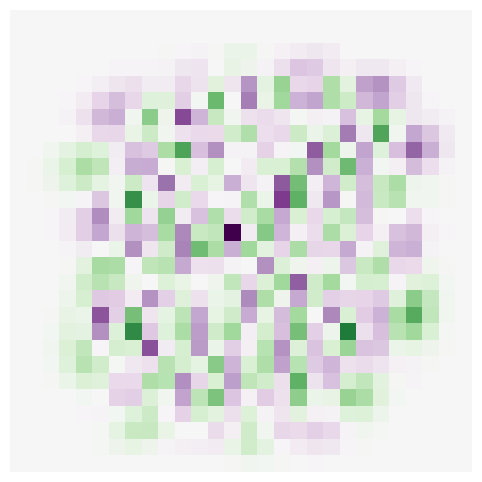

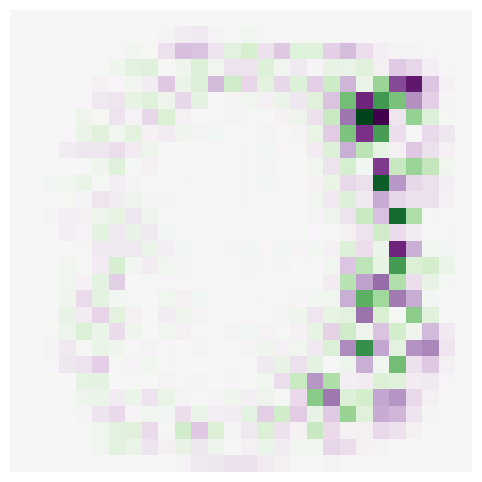

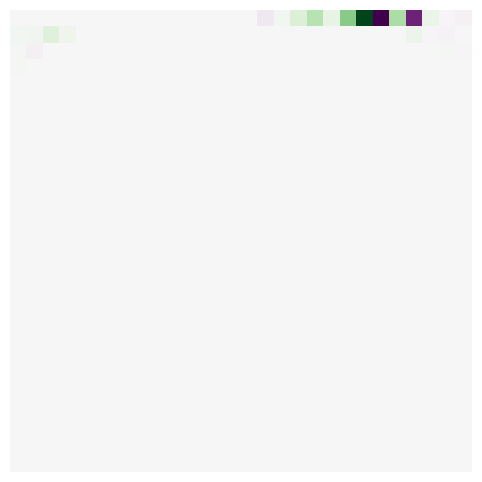

In [82]:


pcs = [0,1,2,100,150,400,-1]
for pc in pcs:
    fig, ax = plt.subplots()
    max_abs = np.max([-np.min(evectors[:,pc]),np.max(evectors[:,pc])])
    ax.imshow(evectors[:,pc].reshape((28,28)), cmap='PRGn', vmin=-max_abs, vmax = max_abs)
    ax.axis('off')
    print (evals[pc])

-235.65100138590105


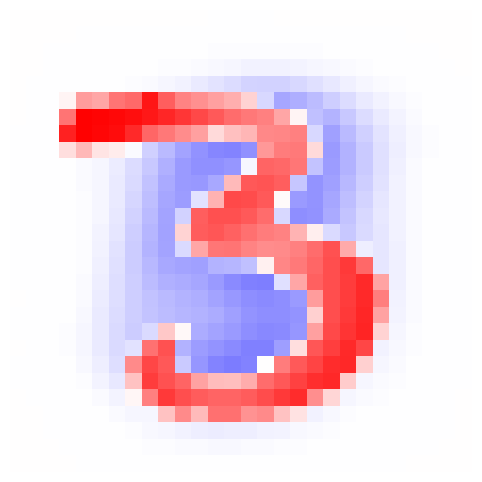

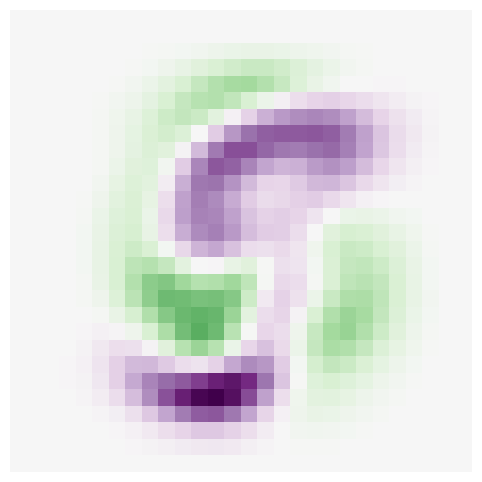

In [144]:
sample = 12 #42, 80 (40)

# fig, ax = plt.subplots()
# ax.imshow((X[sample]).reshape((28,28)), cmap='binary')
# ax.axis('off')

fig, ax = plt.subplots()
ax.imshow((X[sample]-X_mean).reshape((28,28)), cmap='bwr', vmin=-255,vmax=255)
ax.axis('off')

pc = 3
fig, ax = plt.subplots()
max_abs = np.max([-np.min(evectors[:,pc]),np.max(evectors[:,pc])])
ax.imshow(evectors[:,pc].reshape((28,28)), cmap='PRGn', vmin=-max_abs, vmax = max_abs)
ax.axis('off')

print (evectors[:,pc].dot(X[sample]-X_mean).T)

996.7827673111769
649


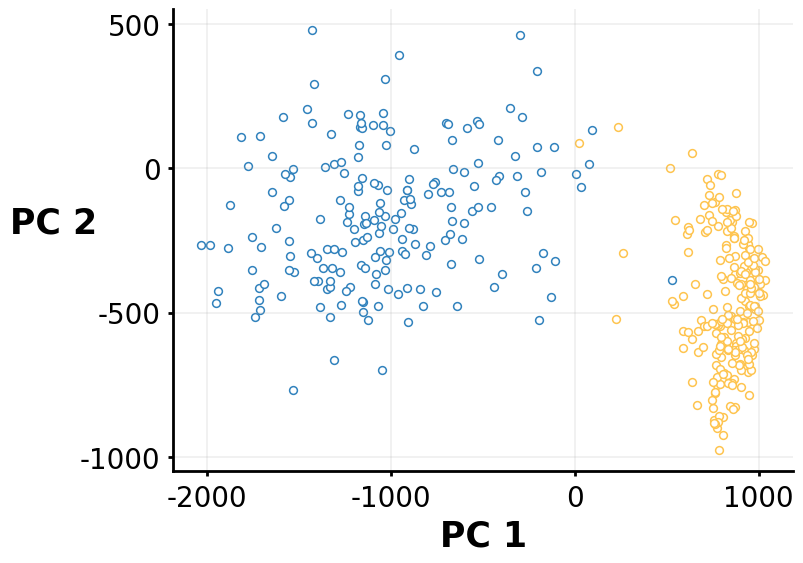

In [125]:
Y = mnist.target.astype(int)

fig, ax = plt.subplots()


Y_tick = Y[:2000]
X_tick = X[:2000]

A = evectors.T.dot((X_tick-X_mean).T)
colors = ['#3182bd','#fec44f']
for tt in [0,1]:
    ax.scatter(A[0][Y_tick == tt],A[1][Y_tick==tt], edgecolor = colors[tt], facecolor='w', linewidth=1.1)
print (A[0][40])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

x_ticks = [-2000,-1000,0,1000]
y_ticks = [-1000,-500,0,500]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks,fontsize=20)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks,fontsize=20)

ax.set_xlabel('PC 1', fontsize=25, fontweight='bold')
ax.set_ylabel('PC 2', fontsize=25, rotation=0, fontweight='bold', labelpad=19)

print (np.argmax(np.abs(evals)<1))

[Text(-500, 0, '-500'),
 Text(0, 0, '0'),
 Text(500, 0, '500'),
 Text(1000, 0, '1000')]

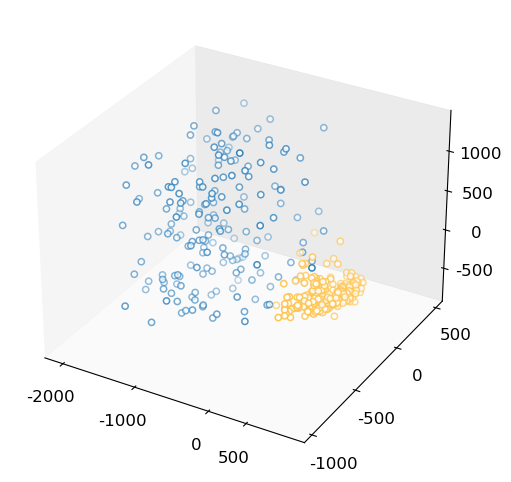

In [130]:
ax = plt.figure().add_subplot(projection='3d')
for tt in [0,1]:
    ax.scatter(A[0][Y_tick == tt],A[1][Y_tick==tt],A[2][Y_tick==tt], edgecolor = colors[tt], facecolor='w', linewidth=1.1)
ax.grid(False)
xticks = [-2000,-1000,0,500]
yticks = [-1000,-500,0,500]
zticks = [-500,0,500,1000]



ax.set(
    xticks = xticks,
#     xlabel = 'PC 1',
    yticks = yticks,
#     ylabel = 'PC 2',
    zticks = zticks,
#     zlabel = 'PC 3',    
)
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.04))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.08))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.02))
ax.set_xticklabels(xticks, fontsize=12)
ax.set_yticklabels(yticks, fontsize=12)
ax.set_zticklabels(zticks, fontsize=12)

[Text(-500, 0, '-500'),
 Text(0, -0.011820818995916216, '0'),
 Text(500, 0.0034993339628539314, '500'),
 Text(1000, 0.019094817712469753, '1000')]